In [1]:
import numpy as np

from pyiron_base import GenericJob, DataContainer 
from pyiron_atomistics.atomistics.structure.has_structure import HasStructure
from pyiron_atomistics.lammps.potential import LammpsPotential, LammpsPotentialFile
from pyiron_atomistics import Project

In [2]:
import os

In [3]:
os.getcwd()

'/home/markus/repos/pyiron_contrib/pyiron_contrib/atomistics/stacking_fault_annni'

In [11]:
class StackingFaultANNNI(GenericJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.input = DataContainer(table_name="inputdata")
        self.output = DataContainer(table_name="output")
    
    @property
    def reference_structure(self):
        return self.input.reference_structure

    @reference_structure.setter
    def reference_structure(self, val):
        self.input.reference_structure = val
    
    @property
    def potential(self):
        return self.input.potential.df
    
    @potential.setter
    def potential(self, name):
        potential = LammpsPotentialFile().find_by_name(name)
        self.input.potential = LammpsPotential()
        self.input.potential.df = potential  
        self.input.potential_name = name
    
    def calc_anni(self, temperature, steps):
        self.input.temperature = temperature
        self.input.steps = steps

    def run_static(self):
        self.status.running = True
        energies = []
        volumes = []
        self._minimize_structure()
        self.sf_structures = self._create_sf_structures()
        lst = [self.minimum_structure, *self.sf_structures]
        # print(lst)
        for structure in lst:
            print(len(structure))
            self._create_ref_job(structure)
            zerok_energy = self._calculate_0K_energy(structure)
            qh_energy, qh_volume = self._calculate_qh_energy_volume(structure)
            energies.append(zerok_energy + qh_energy)
            volumes.append(qh_volume)
        self.output["energy"] = energies
        self.output["volume"] = volumes
        
        if self.minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
            sfe = self._calculate_SFE_fcc(energies[0], energies[1], energies[2], volumes[0])
        else:
            sfe = self._calculate_SFE_hcp(energies[0], energies[1], energies[2], volumes[0])
        
        self.output["stacking_fault_energy"] = sfe
        self.status.collect = True
        self.run()
        
    def _create_hcp_structure(self, minimum_structure):
        supercell_size = round((len(minimum_structure)/4)**(1/3))
        a_fcc = minimum_structure.cell[0][0]/(supercell_size)
        a_hcp = (((a_fcc)**3)/(np.sqrt(3)* (np.sqrt(8/3))))**(1/3)
        element = minimum_structure.get_chemical_symbols()[0]
        hcp_struc = self.project.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp).repeat(supercell_size)
        return hcp_struc

    def _create_fcc_structure(self, minimum_structure):
        supercell_size = round((len(minimum_structure)/2)**(1/3))
        a_hcp = minimum_structure.cell[0][0]/(supercell_size)
        c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
        a_fcc = (((a_hcp)**3)*(np.sqrt(3)* (c_over_a)))**(1/3)
        element = minimum_structure.get_chemical_symbols()[0]
        fcc_struc= self.project.create.structure.bulk(element,crystalstructure="fcc", a=a_fcc, cubic=True).repeat(supercell_size)
        return  fcc_struc

    def _create_dhcp_structure(self, minimum_structure): 
        supercell_size = round((len(minimum_structure)/2)**(1/3))
        a_hcp = minimum_structure.cell[0][0]/(supercell_size)
        c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
        element = minimum_structure.get_chemical_symbols()[0]
        dhcp_unitcell= self.project.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp, covera= c_over_a, orthorhombic=False).repeat([1,1,2])
        new_pos=[]
        for i in range(len(dhcp_unitcell)):
            if i == 3 :
                pos = dhcp_unitcell.get_positions()[i] + [a_hcp/2, -((np.sqrt(3)/2)*a_hcp)/3, 0.0]
            else:
                pos = dhcp_unitcell.get_positions()[i] +[0.0, 0.0, 0.0]   
            new_pos.append(pos)
        dhcp_unitcell.set_positions(new_pos)
        dhcp_hcp_struc = dhcp_unitcell.repeat(supercell_size)
        return dhcp_hcp_struc
    
    def _minimize_structure(self):
        job_mini = self.project.create_job(pr.job_type.Lammps, job_name=f'lmp_mini_{self.job_name}')
        job_mini.structure =  self.input.reference_structure
        job_mini.potential =  self.input.potential_name
        job_mini.calc_minimize(pressure=0.0)
        job_mini.run(delete_existing_job=True)
        self.minimum_structure = job_mini.get_structure() 
    
    def _create_sf_structures(self):
        if self.minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
            SF_structure_1 = self._create_hcp_structure(self.minimum_structure)
            SF_structure_2 = self._create_dhcp_structure(SF_structure_1)
        else:
            SF_structure_1 = self._create_fcc_structure(self.minimum_structure)
            SF_structure_2 = self._create_dhcp_structure(self.minimum_structure)
        return SF_structure_1, SF_structure_2
    
    def _create_ref_job(self, structure):
        job_strain_template = self.project.create.job.Lammps(job_name=f'lmp_{self.job_name}',delete_existing_job=True)
        job_strain_template.potential = self.input.potential_name
        job_strain_template.structure = structure
        self.job_template = job_strain_template 
    
    def _calculate_0K_energy(self, structure):
        murn_strain = self.project.create.job.Murnaghan(job_name=f'Murn_{self.job_name}',delete_existing_job=True)
        murn_strain.ref_job = self.job_template
        murn_strain.run(delete_existing_job=True)
        return ((murn_strain["output/energy"])/len(structure))

    def _calculate_qh_energy_volume(self, structure):
        phono_strain = self.project.create.job.PhonopyJob(job_name=f'phono_{self.job_name}', delete_existing_job=True)
        phono_strain.ref_job = self.job_template
        quasi_strain = self.project.create.job.QuasiHarmonicJob(job_name=f'quasi_{self.job_name}', delete_existing_job=True)
        quasi_strain.ref_job = phono_strain
        quasi_strain.input["temperature_end"] = self.input.temperature
        quasi_strain.input["temperature_steps"] = self.input.steps
        quasi_strain.input["axes"]=["x","y","z"]
        quasi_strain.input["strains"] = None
        quasi_strain.run(delete_existing_job=True)
        energy = (quasi_strain["output/free_energy"].T)/len(structure)
        volume = (quasi_strain["output/volumes"].T)/len(structure)
        return energy, volume
    
    def _calculate_SFE_hcp(self, E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure):
        Ahcp_T       = []
        del_free_eng_I1 = []
        del_free_eng_I2 = []
        SFE_T_I1 = []
        SFE_T_I2 = []
        covera = self.minimum_structure.cell[2][2]/self.minimum_structure.cell[0][0]
        for i in range(len(E_ref_structure)):
            min_index = E_ref_structure[i].argmin()
            Ahcp_T.append(((np.sqrt(3)/2)* ((4*V_ref_structure[i][min_index]/(np.sqrt(3)*covera))**(2/3))))
            del_free_eng_I1.append((2*(E_SF_structure_2[i][min_index]- E_ref_structure[i][min_index]))*1000)
            del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
            SFE_T_I1.append(del_free_eng_I1[i] /Ahcp_T[i])
            SFE_T_I2.append(del_free_eng_I2[i] /Ahcp_T[i])
        return SFE_T_I1, SFE_T_I2

    def _calculate_SFE_fcc(E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure):
        Afcc_T       = []
        del_free_eng_I1 = []
        del_free_eng_I2 = []
        SFE_T_I1 = []
        SFE_T_I2 = []
        for i in range(len(E_ref_structure)):
            min_index = E_ref_structure[i].argmin()
            Afcc_T.append((np.sqrt(3)/4)* ((4*V_ref_structure[i][min_index])**(2/3)))
            del_free_eng_I1.append((2*(E_SF_structure_1[i][min_index]- E_ref_structure[i][min_index]))*1000)
            del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
            SFE_T_I1.append(del_free_eng_I1[i] /Afcc_T[i])
            SFE_T_I2.append(del_free_eng_I2[i] /Afcc_T[i])
        return SFE_T_I1, SFE_T_I2   

    
    def collect_output(self):
        #self.collect_general_output()
        self.to_hdf()
    
    def to_hdf(self, hdf=None, group_name=None):
        super().to_hdf(hdf=hdf, group_name=group_name)
        self.input.to_hdf(self.project_hdf5)
        self.output.to_hdf(self.project_hdf5)

    def from_hdf(self, hdf=None, group_name=None):
        super().from_hdf(hdf=hdf, group_name=group_name)
        self.input.from_hdf(self.project_hdf5)
        self.output.from_hdf(self.project_hdf5)    


In [12]:
pr = Project("prototype_2")


In [13]:
job = pr.create_job(job_type= StackingFaultANNNI, job_name="prototype_2", delete_existing_job=True)

In [14]:
job.reference_structure = pr.create.structure.bulk('Mg', a = 3.21, orthorhombic=False).repeat(2)

In [15]:
job.potential = '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1'

In [16]:
job.calc_anni(temperature=200, steps=5)

In [17]:
job.run()

The job prototype_2 was saved and received the ID: 566
The job lmp_mini_prototype_2 was saved and received the ID: 567
16
The job Murn_prototype_2 was saved and received the ID: 568
The job Murn_prototype_2_0_9 was saved and received the ID: 569
The job Murn_prototype_2_0_92 was saved and received the ID: 570
The job Murn_prototype_2_0_94 was saved and received the ID: 571
The job Murn_prototype_2_0_96 was saved and received the ID: 572
The job Murn_prototype_2_0_98 was saved and received the ID: 573
The job Murn_prototype_2_1_0 was saved and received the ID: 574
The job Murn_prototype_2_1_02 was saved and received the ID: 575
The job Murn_prototype_2_1_04 was saved and received the ID: 576
The job Murn_prototype_2_1_06 was saved and received the ID: 577
The job Murn_prototype_2_1_08 was saved and received the ID: 578
The job Murn_prototype_2_1_1 was saved and received the ID: 579
The job quasi_prototype_2 was saved and received the ID: 580
The job quasi_prototype_2_0_9 was saved and r

In [30]:
sf_e = np.array(job.output["stacking_fault_energy"])
sf_e

array([[0.90329314, 0.90190845, 0.86974142, 0.8577834 , 0.84439283],
       [1.79792616, 1.79497758, 1.73073368, 1.70638946, 1.67917117]])

In [31]:
import matplotlib.pyplot as plt

In [35]:
sf_e.shape


(2, 5)

[  0.  50. 100. 150. 200.]


Text(0.5, 1.0, 'SF I1 in meV/A^2')

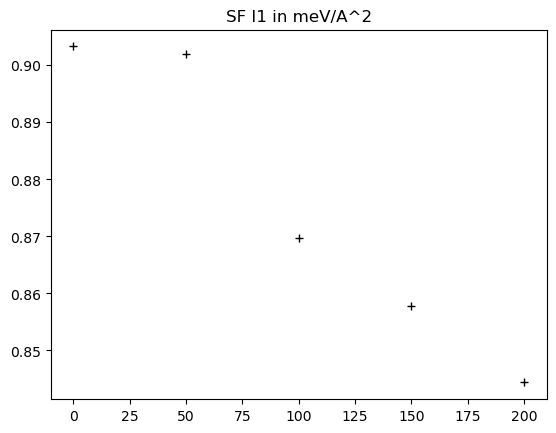

In [51]:
step_size = 200/4
temp = np.arange(0,200 + step_size,step_size)
print(temp)
plt.plot(temp, sf_e[0,:],'k+')
plt.title("SF I1 in meV/A^2")

Text(0.5, 1.0, 'SF I2 in meV/A^2')

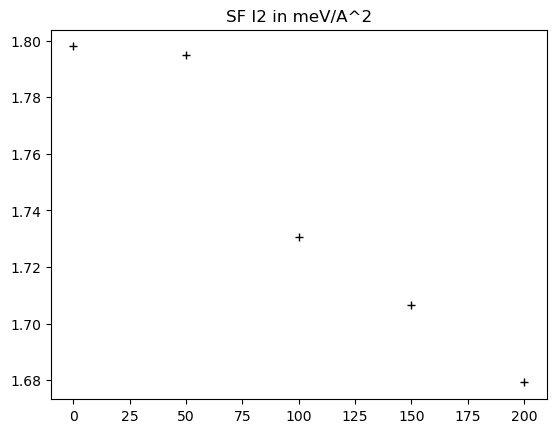

In [52]:
plt.plot(temp, sf_e[1,:],'k+')
plt.title("SF I2 in meV/A^2")